In [1]:
import pandas as pd

# Load training and test datasets
train_df = pd.read_csv('processed_train.csv')
test_df = pd.read_csv('processed_test.csv')

# Display basic info
print("Training Data:")
print(train_df.info())

print("\nTest Data:")
print(test_df.info())


Training Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93665 entries, 0 to 93664
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   category             93665 non-null  object
 1   sub_category         93665 non-null  object
 2   crimeaditionalinfo   93665 non-null  object
 3   corrected_text       92463 non-null  object
 4   tokens               93665 non-null  object
 5   domain_tags          93665 non-null  object
 6   pos_tags             93665 non-null  object
 7   filtered_tokens_pos  93665 non-null  object
 8   filtered_tokens      93665 non-null  object
dtypes: object(9)
memory usage: 6.4+ MB
None

Test Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31229 entries, 0 to 31228
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   category            31229 non-null  object
 1   sub_category        2899

In [2]:
# Remove rows with missing values
train_df = train_df.dropna()
test_df = test_df.dropna()

print("Training Data Shape After Removing Missing Values:", train_df.shape)
print("Test Data Shape After Removing Missing Values:", test_df.shape)


Training Data Shape After Removing Missing Values: (92463, 9)
Test Data Shape After Removing Missing Values: (28623, 8)


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

# Enable tqdm for pandas
tqdm.pandas()

# Initialize vectorizers and encoders
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limit features for efficiency
category_encoder = LabelEncoder()
subcategory_encoder = LabelEncoder()

# Ensure 'filtered_tokens_pos' is a string of space-separated tokens
def preprocess_tokens(tokens_pos):
    if isinstance(tokens_pos, str):
        return tokens_pos  # If already a string
    elif isinstance(tokens_pos, list):
        return ' '.join(tokens_pos)  # Convert list of tokens to a space-separated string
    else:
        return ''  # Handle edge cases (e.g., NaN)

# Process training data with progress tracking
train_df['processed_tokens'] = train_df['filtered_tokens_pos'].progress_apply(preprocess_tokens)
X_train_text = tfidf_vectorizer.fit_transform(train_df['processed_tokens'])
y_train_category = category_encoder.fit_transform(train_df['category'])
y_train_subcategory = subcategory_encoder.fit_transform(train_df['sub_category'])




100%|████████████████████████████████████████████████████████████████████████| 92463/92463 [00:00<00:00, 984461.89it/s]


In [7]:
# Debugging Code
unseen_categories = set(test_df['category']) - set(category_encoder.classes_)
print("Unseen Categories:", unseen_categories)

unseen_subcategories = set(test_df['sub_category']) - set(subcategory_encoder.classes_)
print("Unseen Subcategories:", unseen_subcategories)

unseen_category_rows = test_df[test_df['category'].isin(unseen_categories)]
unseen_subcategory_rows = test_df[test_df['sub_category'].isin(unseen_subcategories)]

print("Rows with unseen categories:")
print(unseen_category_rows)

print("Rows with unseen subcategories:")
print(unseen_subcategory_rows)
# Define unseen labels to remove
unseen_categories = {'Crime Against Women & Children'}
unseen_subcategories = {'Computer Generated CSAM/CSEM', 'Cyber Blackmailing & Threatening', 'Sexual Harassment'}

# Remove rows with unseen categories and subcategories
test_df = test_df[
    ~test_df['category'].isin(unseen_categories) &
    ~test_df['sub_category'].isin(unseen_subcategories)
]

# Verify the updated dataframe
print(f"Updated Test Dataset Size: {test_df.shape}")





Unseen Categories: {'Crime Against Women & Children'}
Unseen Subcategories: {'Computer Generated CSAM/CSEM', 'Cyber Blackmailing & Threatening', 'Sexual Harassment'}
Rows with unseen categories:
                             category                      sub_category  \
2762   Crime Against Women & Children      Computer Generated CSAM/CSEM   
9517   Crime Against Women & Children      Computer Generated CSAM/CSEM   
14779  Crime Against Women & Children  Cyber Blackmailing & Threatening   
19725  Crime Against Women & Children                 Sexual Harassment   

                                      crimeaditionalinfo  \
2762   My friend mentioned something like this happen...   
9517   The issue actually started when I got this ema...   
14779  My friend mentioned something like this happen...   
19725  I never imagined something like this could hap...   

                                          corrected_text  \
2762   my friend mentioned something like this happen...   
9517   t

In [8]:
# Process test data with progress tracking
test_df['processed_tokens'] = test_df['filtered_tokens'].progress_apply(preprocess_tokens)
X_test_text = tfidf_vectorizer.transform(test_df['processed_tokens'])
y_test_category = category_encoder.transform(test_df['category'])
y_test_subcategory = subcategory_encoder.transform(test_df['sub_category'])

# Display feature shapes
print("Text Features Shape (Train):", X_train_text.shape)
print("Text Features Shape (Test):", X_test_text.shape)

100%|████████████████████████████████████████████████████████████████████████| 28619/28619 [00:00<00:00, 727015.40it/s]
C:\Users\hp\AppData\Local\Temp\ipykernel_3388\319857076.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['processed_tokens'] = test_df['filtered_tokens'].progress_apply(preprocess_tokens)


Text Features Shape (Train): (92463, 5000)
Text Features Shape (Test): (28619, 5000)


In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from tqdm import tqdm
import numpy as np

# Initialize the subcategory model with parallelization (using all available cores)
subcategory_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

# Wrap training in a progress-tracked context
print("Training the subcategory model...")
with tqdm(total=1, desc="Training Progress") as pbar:
    subcategory_model.fit(X_train_text, y_train_subcategory)
    pbar.update(1)  # Update the progress bar when training completes

# Predict subcategory on the test data
print("Making predictions...")
y_pred_subcategory = subcategory_model.predict(X_test_text)  # Directly predict on the full sparse matrix

# Evaluate the subcategory model
print("Subcategory Classification Report:\n", classification_report(y_test_subcategory, y_pred_subcategory))


Training the subcategory model...


Training Progress: 100%|████████████████████████████████████████████████████████████████| 1/1 [03:49<00:00, 229.46s/it]


Making predictions...
Subcategory Classification Report:
               precision    recall  f1-score   support

           1       0.33      0.01      0.02        90
           2       0.64      0.01      0.02       711
           3       0.78      0.18      0.29       165
           4       0.64      0.56      0.60      1340
           5       0.00      0.00      0.00        51
           6       1.00      0.03      0.05        36
           7       0.18      0.16      0.17       171
           8       0.68      0.70      0.69      3523
           9       0.30      0.01      0.03       220
          10       0.17      0.16      0.16       187
          11       0.50      0.02      0.04        54
          12       0.73      0.34      0.46      1313
          13       0.85      0.08      0.15       130
          14       0.63      0.36      0.46       748
          15       0.33      0.10      0.16      1794
          16       0.15      0.12      0.14       200
          17       0.00

C:\ML\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ML\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ML\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ML\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-de

In [13]:
# Check for unseen labels in predictions
unseen_labels_pred = set(y_pred_subcategory) - set(subcategory_encoder.classes_)
unseen_labels_train = set(y_train_subcategory) - set(subcategory_encoder.classes_)

print("Unseen Labels in Predictions:", unseen_labels_pred)
print("Unseen Labels in Training:", unseen_labels_train)

# Debugging rows with unseen labels
if unseen_labels_pred or unseen_labels_train:
    print("Rows in y_pred_subcategory with unseen labels:", y_pred_subcategory[y_pred_subcategory == unseen_labels_pred])
    print("Rows in y_train_subcategory with unseen labels:", y_train_subcategory[y_train_subcategory == unseen_labels_train])

# Map unseen labels to "Other"
def map_unseen_labels(y, encoder_classes):
    return np.array([
        label if label in encoder_classes else "Other"
        for label in y
    ])

# Map predictions and training data to valid classes
y_pred_subcategory_fixed = map_unseen_labels(y_pred_subcategory, subcategory_encoder.classes_)
y_train_subcategory_fixed = map_unseen_labels(y_train_subcategory, subcategory_encoder.classes_)

# Transform again to ensure compatibility
predicted_subcategory_encoded = subcategory_encoder.transform(y_pred_subcategory_fixed)
predicted_subcategory_encoded_train = subcategory_encoder.transform(y_train_subcategory_fixed)


Unseen Labels in Predictions: {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 25, 26, 27, 29, 30, 31, 32, 33, 34}
Unseen Labels in Training: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35}
Rows in y_pred_subcategory with unseen labels: []
Rows in y_train_subcategory with unseen labels: []


In [14]:
from lightgbm import LGBMClassifier

# Combine features for training and test datasets
X_train_combined = hstack([
    X_train_text,
    np.array(predicted_subcategory_encoded_train).reshape(-1, 1)
])
X_test_combined = hstack([
    X_test_text,
    np.array(predicted_subcategory_encoded).reshape(-1, 1)
])

# Train the category model
category_model = LGBMClassifier(random_state=42)
category_model.fit(X_train_combined, y_train_category)

# Predict and evaluate
y_pred_category = category_model.predict(X_test_combined)
print("Category Classification Report:\n", classification_report(y_test_category, y_pred_category))


C:\ML\lib\site-packages\lightgbm\basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


Category Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.21      0.28      3624
           1       0.00      0.00      0.00         0
           2       0.33      0.44      0.38       165
           3       1.00      0.99      1.00      1261
           4       0.00      0.00      0.00        51
           5       0.32      0.25      0.28       580
           6       0.00      0.00      0.00        61
           7       0.82      0.91      0.86     18660
           8       0.13      0.09      0.11       133
           9       0.66      0.50      0.57      4066
          10       0.01      0.11      0.02        18
          11       0.00      0.00      0.00         0
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0

    accuracy                           0.74     28619
   macro avg       0.26      0.25      0.25     28619
weighted avg       0.74      0.74      0.73    

C:\ML\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ML\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ML\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [15]:
import joblib

# Save the subcategory model
joblib.dump(subcategory_model, 'LGBM_subcategory_model.pkl')

# Save the category model
joblib.dump(category_model, 'LGBM_category_model.pkl')

print("Models saved successfully.")


Models saved successfully.


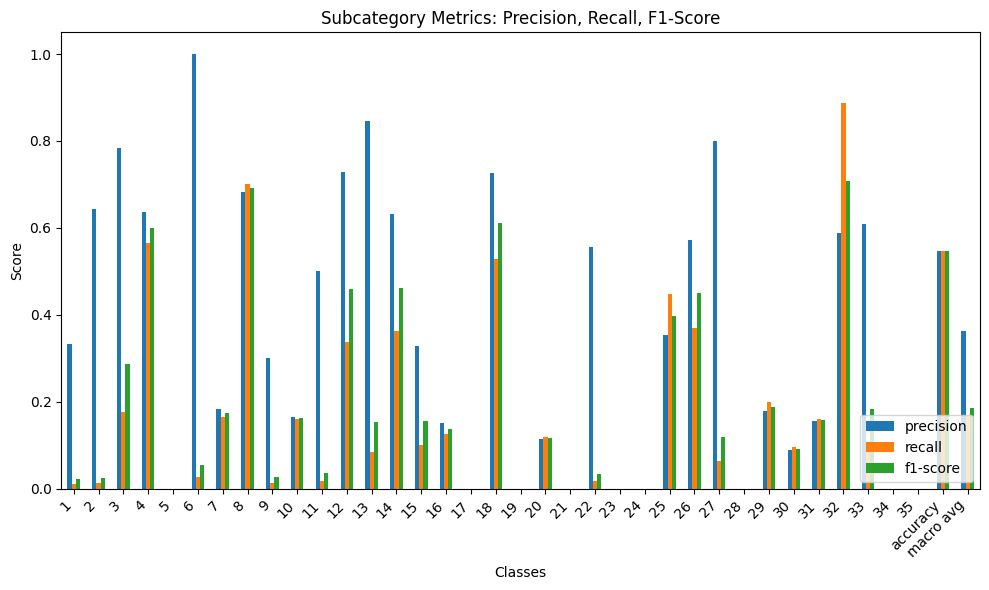

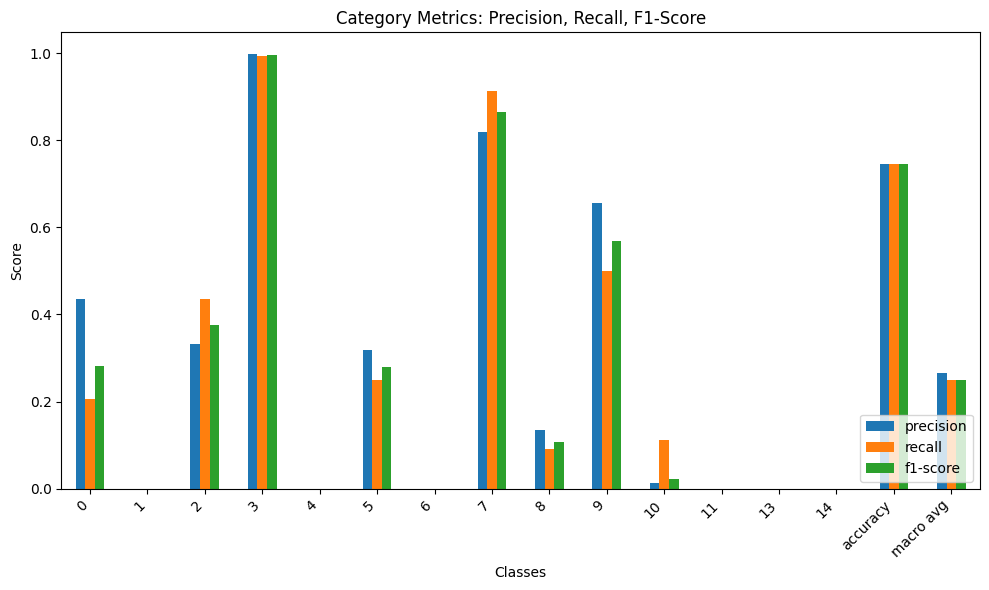

In [18]:
# Visualization for Subcategory Metrics
subcategory_metrics = subcategory_report_df[['precision', 'recall', 'f1-score']].iloc[:-1]  # Exclude 'accuracy'
ax = subcategory_metrics.plot(kind='bar', figsize=(10, 6))

# Set the ticks and labels explicitly
ax.set_xticks(range(len(subcategory_metrics)))
ax.set_xticklabels(subcategory_metrics.index, rotation=45, ha='right')

# Add titles and labels
plt.title("Subcategory Metrics: Precision, Recall, F1-Score")
plt.ylabel("Score")
plt.xlabel("Classes")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# Visualization for Category Metrics
category_metrics = category_report_df[['precision', 'recall', 'f1-score']].iloc[:-1]  # Exclude 'accuracy'
ax = category_metrics.plot(kind='bar', figsize=(10, 6))

# Set the ticks and labels explicitly
ax.set_xticks(range(len(category_metrics)))
ax.set_xticklabels(category_metrics.index, rotation=45, ha='right')

# Add titles and labels
plt.title("Category Metrics: Precision, Recall, F1-Score")
plt.ylabel("Score")
plt.xlabel("Classes")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


In [21]:
# Decode subcategory predictions back to their original names
decoded_subcategory_names = subcategory_encoder.inverse_transform(
    [i for i in range(len(subcategory_encoder.classes_))]
)

# Decode category predictions back to their original names
decoded_category_names = category_encoder.inverse_transform(
    [i for i in range(len(category_encoder.classes_))]
)


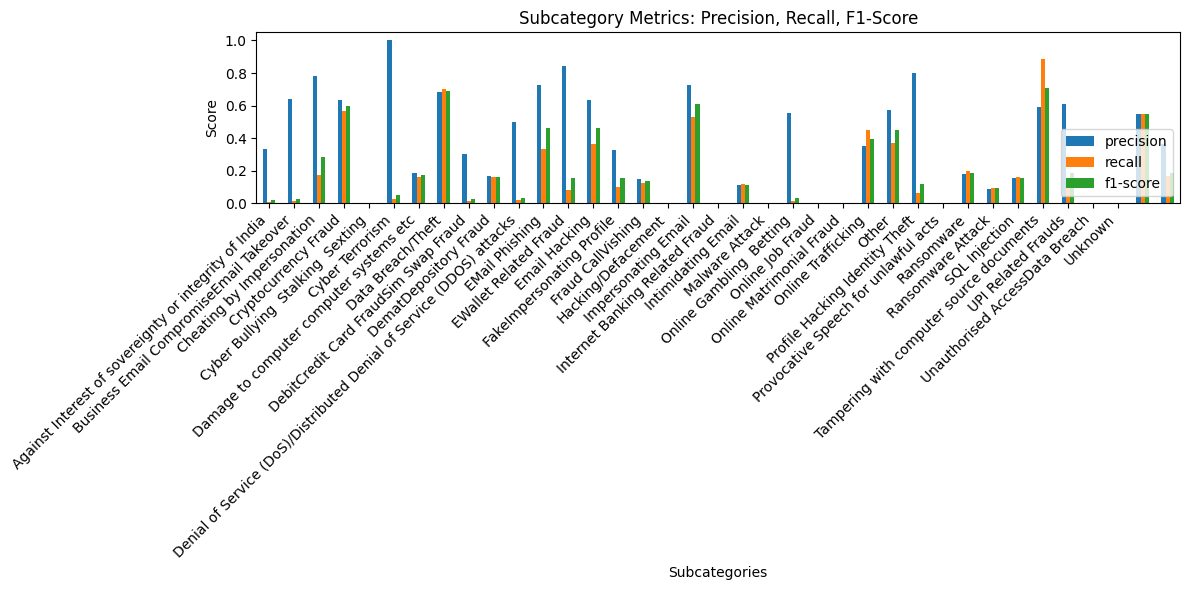

In [23]:
# Visualization for Subcategory Metrics
subcategory_metrics = subcategory_report_df[['precision', 'recall', 'f1-score']].iloc[:-1]  # Exclude 'accuracy'

# Plot bar chart
ax = subcategory_metrics.plot(kind='bar', figsize=(12, 6))

# Use decoded subcategory names for x-axis labels
subcategory_names = decoded_subcategory_names[:-1]  # Exclude 'accuracy' row
ax.set_xticks(range(len(subcategory_names)))
ax.set_xticklabels(subcategory_names, rotation=45, ha='right')

# Add titles and labels
plt.title("Subcategory Metrics: Precision, Recall, F1-Score")
plt.ylabel("Score")
plt.xlabel("Subcategories")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


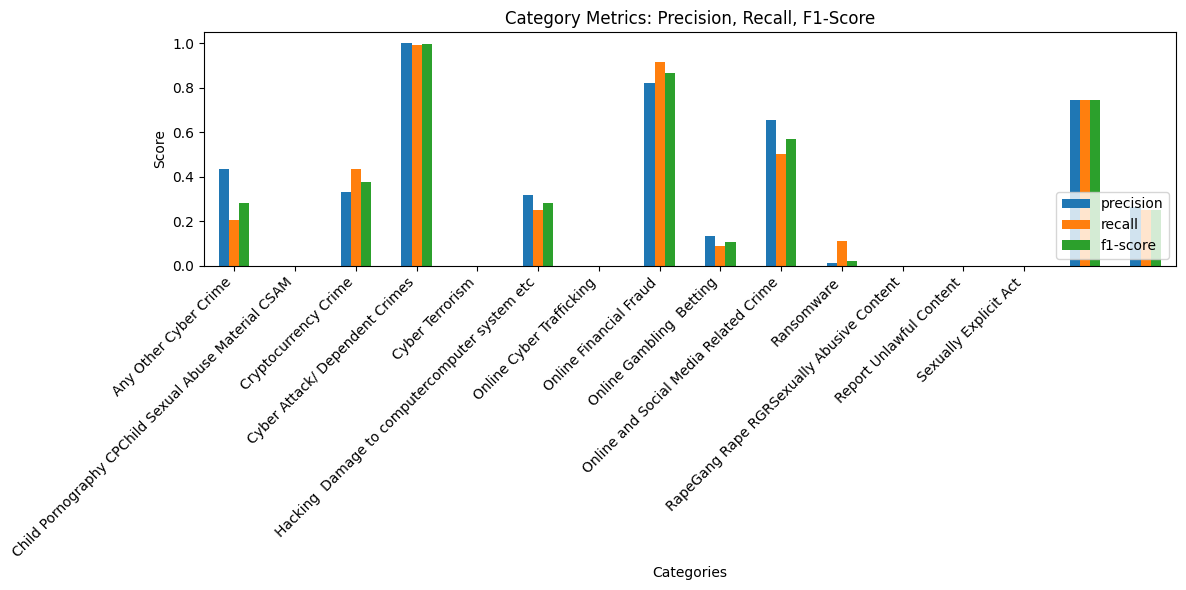

In [24]:
# Visualization for Category Metrics
category_metrics = category_report_df[['precision', 'recall', 'f1-score']].iloc[:-1]  # Exclude 'accuracy'

# Plot bar chart
ax = category_metrics.plot(kind='bar', figsize=(12, 6))

# Use decoded category names for x-axis labels
category_names = decoded_category_names[:-1]  # Exclude 'accuracy' row
ax.set_xticks(range(len(category_names)))
ax.set_xticklabels(category_names, rotation=45, ha='right')

# Add titles and labels
plt.title("Category Metrics: Precision, Recall, F1-Score")
plt.ylabel("Score")
plt.xlabel("Categories")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


C:\ML\lib\site-packages\lightgbm\basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


Skipping class Child Pornography CPChild Sexual Abuse Material CSAM: no positive samples in y_true
Skipping class RapeGang Rape RGRSexually Abusive Content: no positive samples in y_true
Skipping class Report Unlawful Content: no positive samples in y_true
Skipping class Sexually Explicit Act: no positive samples in y_true
Skipping class Sexually Obscene material: no positive samples in y_true


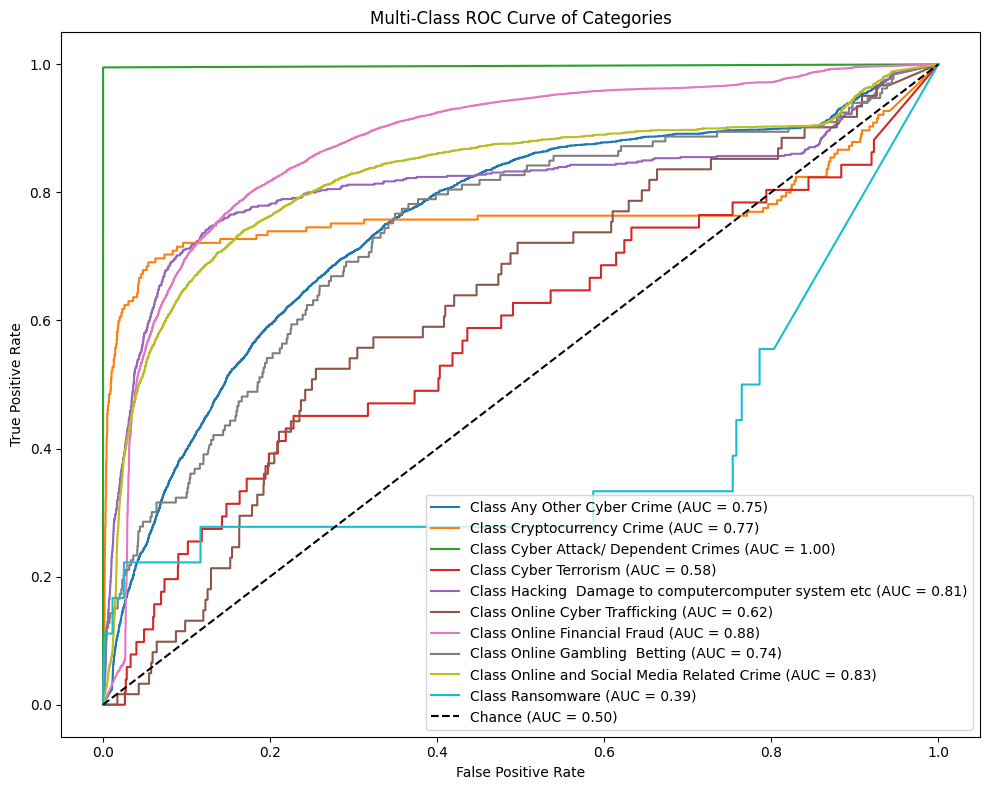

In [28]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize the ground truth labels for multi-class classification
y_test_binary = label_binarize(y_test_category, classes=range(len(category_encoder.classes_)))
y_proba = category_model.predict_proba(X_test_combined)

# Number of classes
n_classes = y_test_binary.shape[1]

# Initialize the plot
plt.figure(figsize=(10, 8))

# Iterate over each class
for i in range(n_classes):
    # Check if the class has at least one positive sample
    if np.sum(y_test_binary[:, i]) == 0:
        print(f"Skipping class {category_encoder.inverse_transform([i])[0]}: no positive samples in y_true")
        continue

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test_binary[:, i], y_proba[:, i])
    auc = roc_auc_score(y_test_binary[:, i], y_proba[:, i])
    plt.plot(fpr, tpr, label=f"Class {category_encoder.inverse_transform([i])[0]} (AUC = {auc:.2f})")

# Plot the diagonal
plt.plot([0, 1], [0, 1], 'k--', label="Chance (AUC = 0.50)")

# Add labels and legend
plt.title("Multi-Class ROC Curve of Categories")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


Skipping subcategory Against Interest of sovereignty or integrity of India: no positive samples in y_true
Skipping subcategory Unknown: no positive samples in y_true


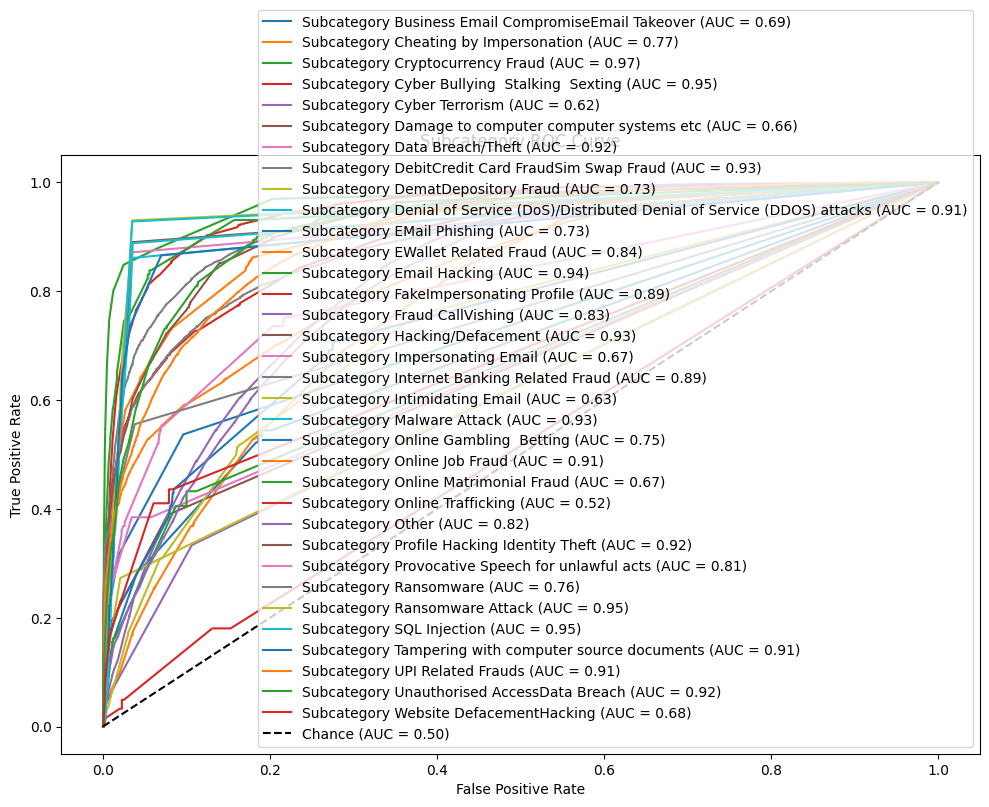

In [29]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Binarize the ground truth labels for multi-class classification (subcategories)
y_test_binary_sub = label_binarize(y_test_subcategory, classes=range(len(subcategory_encoder.classes_)))
y_proba_sub = subcategory_model.predict_proba(X_test_text)

# Number of subcategory classes
n_subclasses = y_test_binary_sub.shape[1]

# Initialize the plot
plt.figure(figsize=(10, 8))

# Iterate over each subcategory class
for i in range(n_subclasses):
    # Check if the subcategory class has at least one positive sample
    if np.sum(y_test_binary_sub[:, i]) == 0:
        print(f"Skipping subcategory {subcategory_encoder.inverse_transform([i])[0]}: no positive samples in y_true")
        continue

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test_binary_sub[:, i], y_proba_sub[:, i])
    auc = roc_auc_score(y_test_binary_sub[:, i], y_proba_sub[:, i])
    plt.plot(fpr, tpr, label=f"Subcategory {subcategory_encoder.inverse_transform([i])[0]} (AUC = {auc:.2f})")

# Plot the diagonal
plt.plot([0, 1], [0, 1], 'k--', label="Chance (AUC = 0.50)")

# Add labels and legend
plt.title("Subcategory ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


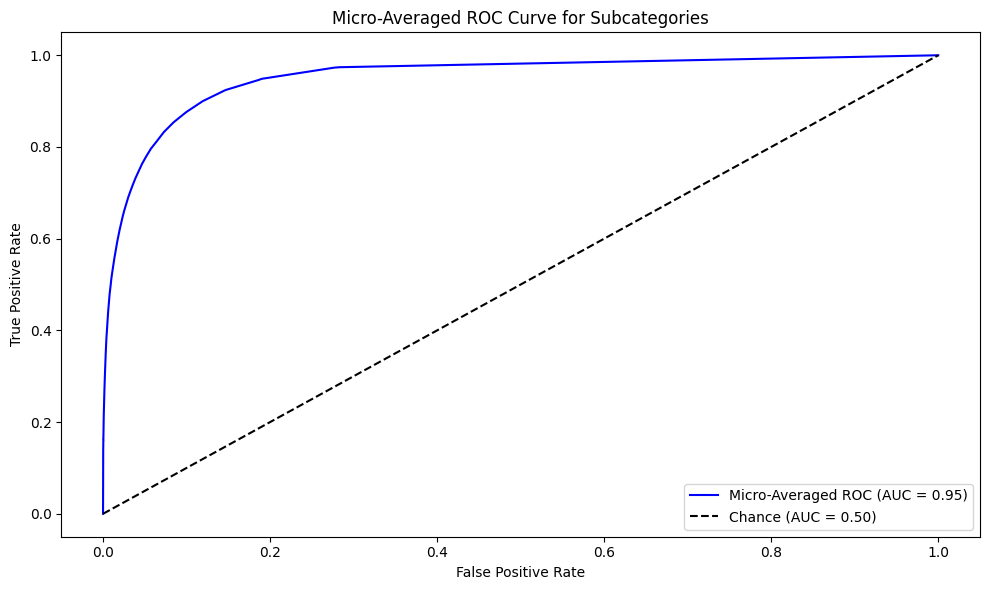

In [32]:
# Compute micro-averaged ROC curve and AUC
fpr_micro, tpr_micro, _ = roc_curve(y_test_binary_sub.ravel(), y_proba_sub.ravel())
auc_micro = roc_auc_score(y_test_binary_sub, y_proba_sub, average="micro")

# Plot the micro-averaged ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_micro, tpr_micro, label=f"Micro-Averaged ROC (AUC = {auc_micro:.2f})", color='blue')

# Plot the diagonal
plt.plot([0, 1], [0, 1], 'k--', label="Chance (AUC = 0.50)")

# Add labels and legend
plt.title("Micro-Averaged ROC Curve for Subcategories")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


C:\ML\lib\site-packages\lightgbm\basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


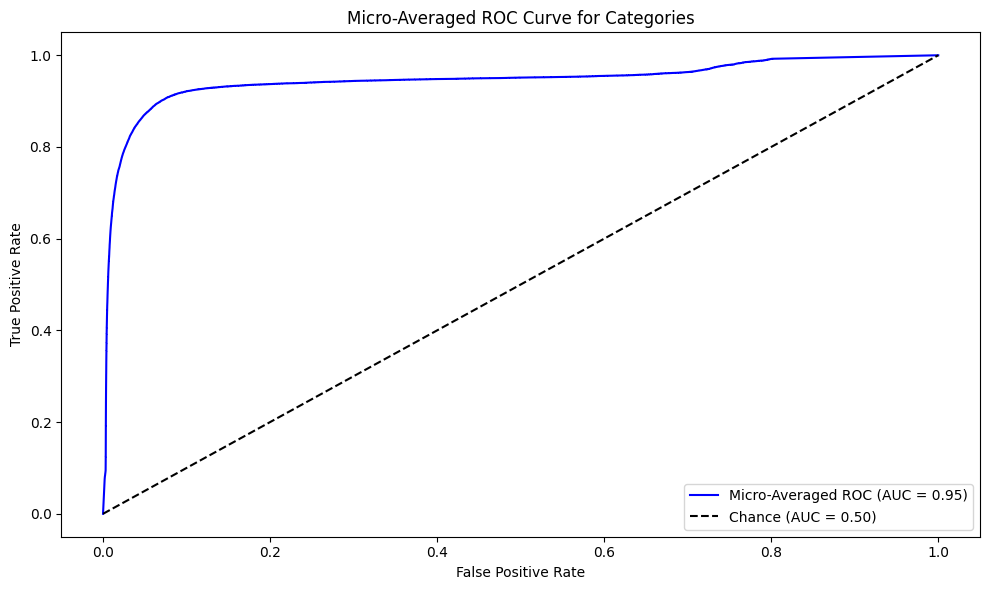

In [34]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Binarize the ground truth labels for multi-class classification (categories)
y_test_binary_cat = label_binarize(y_test_category, classes=range(len(category_encoder.classes_)))
y_proba_cat = category_model.predict_proba(X_test_combined)

# Compute micro-averaged ROC curve and AUC
fpr_micro, tpr_micro, _ = roc_curve(y_test_binary_cat.ravel(), y_proba_cat.ravel())
auc_micro = roc_auc_score(y_test_binary_cat, y_proba_cat, average="micro")

# Plot the micro-averaged ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_micro, tpr_micro, label=f"Micro-Averaged ROC (AUC = {auc_micro:.2f})", color='blue')

# Plot the diagonal
plt.plot([0, 1], [0, 1], 'k--', label="Chance (AUC = 0.50)")

# Add labels and legend
plt.title("Micro-Averaged ROC Curve for Categories")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()


In [37]:
# Convert sparse TF-IDF matrices to dense arrays
X_train_dense = X_train_text.toarray()
X_test_dense = X_test_text.toarray()

print("Converted TF-IDF features to dense arrays.")


Converted TF-IDF features to dense arrays.


In [40]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.utils import to_categorical

# One-hot encode subcategory labels
y_train_subcategory_encoded = to_categorical(y_train_subcategory)
y_test_subcategory_encoded = to_categorical(y_test_subcategory)

# Define the LSTM model for subcategories
subcategory_model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_dense.shape[1],)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(y_train_subcategory_encoded.shape[1], activation='softmax')  # Output layer
])

subcategory_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
subcategory_model.summary()

# Train the subcategory model
subcategory_history = subcategory_model.fit(
    X_train_dense,
    y_train_subcategory_encoded,
    validation_data=(X_test_dense, y_test_subcategory_encoded),
    epochs=100,
    batch_size=32,
    verbose=1
)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 256)               1280256   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dense_8 (Dense)             (None, 36)                4644      
                                                                 
Total params: 1,317,796
Trainable params: 1,317,796
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
2890/2890 [==============================] - 51s 18ms/step - loss: 1.4765 - accuracy: 0.5363 - val_loss: 1.3972 - val_accuracy: 0.5525
Epoch 2/100
2890/2890 [======

Epoch 50/100
2890/2890 [==============================] - 49s 17ms/step - loss: 0.1688 - accuracy: 0.9371 - val_loss: 5.9272 - val_accuracy: 0.5115
Epoch 51/100
2890/2890 [==============================] - 49s 17ms/step - loss: 0.1690 - accuracy: 0.9371 - val_loss: 6.0096 - val_accuracy: 0.5127
Epoch 52/100
2890/2890 [==============================] - 49s 17ms/step - loss: 0.1679 - accuracy: 0.9374 - val_loss: 6.0053 - val_accuracy: 0.5163
Epoch 53/100
2890/2890 [==============================] - 49s 17ms/step - loss: 0.1674 - accuracy: 0.9375 - val_loss: 5.9832 - val_accuracy: 0.5148
Epoch 54/100
2890/2890 [==============================] - 49s 17ms/step - loss: 0.1664 - accuracy: 0.9372 - val_loss: 6.0078 - val_accuracy: 0.5120
Epoch 55/100
2890/2890 [==============================] - 49s 17ms/step - loss: 0.1651 - accuracy: 0.9375 - val_loss: 5.9892 - val_accuracy: 0.5058
Epoch 56/100
2890/2890 [==============================] - 51s 18ms/step - loss: 0.1664 - accuracy: 0.9386 - val_

In [41]:
# Predict subcategories on the test set
y_pred_subcategory_proba = subcategory_model.predict(X_test_dense)
y_pred_subcategory = y_pred_subcategory_proba.argmax(axis=1)  # Convert probabilities to class indices

# Add predicted subcategories as features
X_train_combined = np.hstack([X_train_dense, y_train_subcategory.reshape(-1, 1)])
X_test_combined = np.hstack([X_test_dense, y_pred_subcategory.reshape(-1, 1)])

print("Added predicted subcategories as features.")


895/895 [==============================] - 3s 3ms/step
Added predicted subcategories as features.


In [45]:
from keras.utils import to_categorical

# Ensure consistent label encoding
y_train_category = category_encoder.fit_transform(train_df['category'])
y_test_category = category_encoder.transform(test_df['category'])

# One-hot encode the labels
y_train_category_encoded = to_categorical(y_train_category, num_classes=len(category_encoder.classes_))
y_test_category_encoded = to_categorical(y_test_category, num_classes=len(category_encoder.classes_))

# Define the LSTM model for categories
category_model = Sequential([
    Dense(256, activation='relu', input_shape=(X_train_combined.shape[1],)),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dense(len(category_encoder.classes_), activation='softmax')  # Match output layer to number of classes
])

category_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
category_model.summary()

# Train the model
category_history = category_model.fit(
    X_train_combined,
    y_train_category_encoded,
    validation_data=(X_test_combined, y_test_category_encoded),
    epochs=25,
    batch_size=32,
    verbose=1
)


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 256)               1280512   
                                                                 
 dropout_5 (Dropout)         (None, 256)               0         
                                                                 
 dense_16 (Dense)            (None, 128)               32896     
                                                                 
 dense_17 (Dense)            (None, 15)                1935      
                                                                 
Total params: 1,315,343
Trainable params: 1,315,343
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
2890/2890 [==============================] - 59s 20ms/step - loss: 0.4334 - accuracy: 0.8588 - val_loss: 2.1480 - val_accuracy: 0.7337
Epoch 2/25
2890/2890 [========

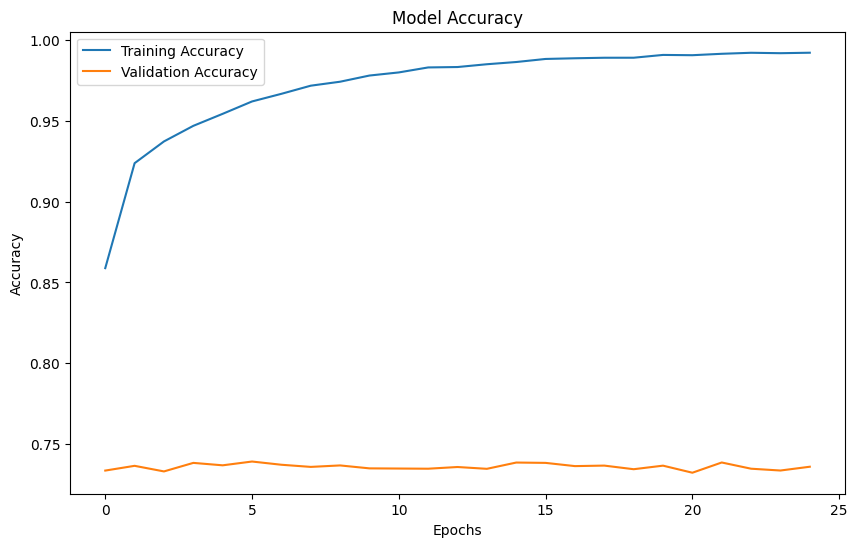

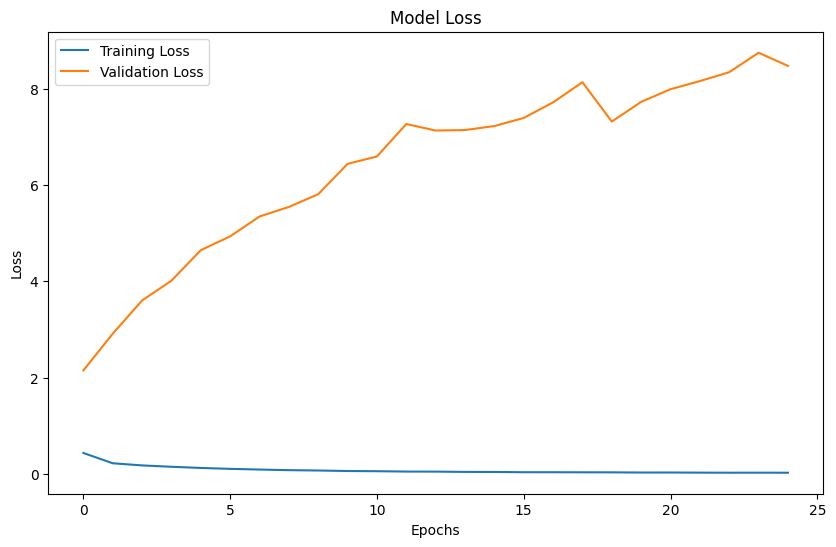

In [49]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(category_history.history['accuracy'], label='Training Accuracy')
plt.plot(category_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(category_history.history['loss'], label='Training Loss')
plt.plot(category_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


895/895 [==============================] - 2s 2ms/step
Category Test Accuracy: 0.7360844194416297
Category Classification Report:
                                                       precision    recall  f1-score   support

                               Any Other Cyber Crime       0.35      0.39      0.37      3624
Child Pornography CPChild Sexual Abuse Material CSAM       0.00      0.00      0.00         0
                                Cryptocurrency Crime       0.53      0.56      0.54       165
                      Cyber Attack/ Dependent Crimes       1.00      1.00      1.00      1261
                                     Cyber Terrorism       0.06      0.02      0.03        51
      Hacking  Damage to computercomputer system etc       0.33      0.26      0.29       580
                            Online Cyber Trafficking       0.00      0.00      0.00        61
                              Online Financial Fraud       0.86      0.87      0.87     18660
                      

C:\ML\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ML\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ML\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ML\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision

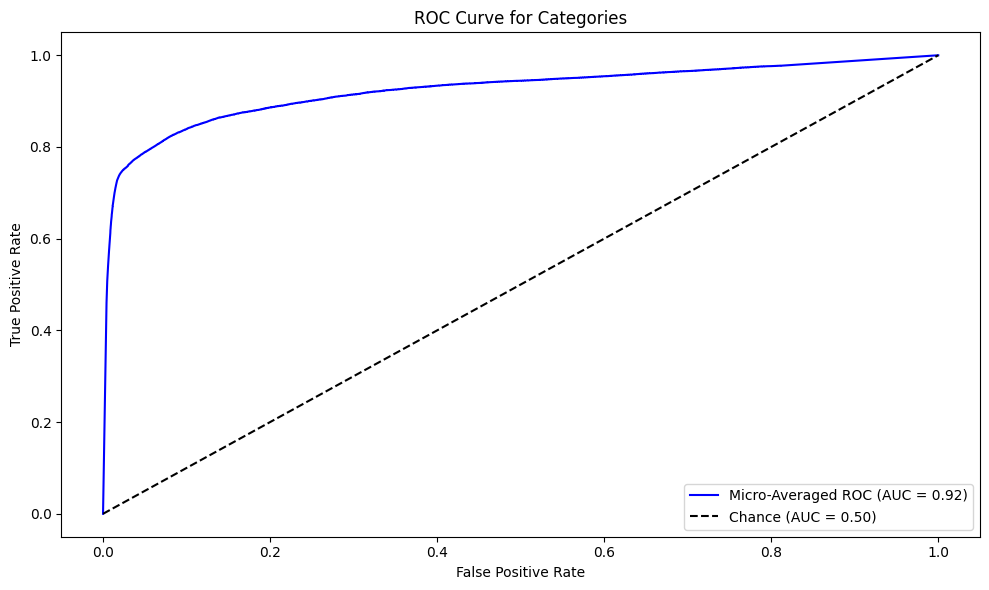

<Figure size 1200x800 with 0 Axes>

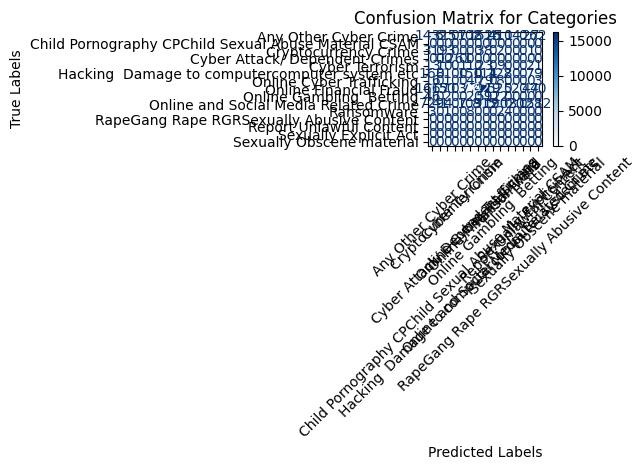

In [52]:
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from keras.utils import to_categorical

# Step 1: Generate predictions for test data
y_pred_category_proba = category_model.predict(X_test_combined)
y_pred_category = y_pred_category_proba.argmax(axis=1)

# Step 2: Calculate accuracy and classification report
labels = list(range(len(category_encoder.classes_)))

category_accuracy = accuracy_score(y_test_category, y_pred_category)
print("Category Test Accuracy:", category_accuracy)

print("Category Classification Report:\n", 
      classification_report(y_test_category, y_pred_category, target_names=category_encoder.classes_, labels=labels))

# Step 3: Plot ROC curve
y_test_category_binary = to_categorical(y_test_category, num_classes=len(category_encoder.classes_))

fpr, tpr, _ = roc_curve(y_test_category_binary.ravel(), y_pred_category_proba.ravel())
auc = roc_auc_score(y_test_category_binary, y_pred_category_proba, average="micro")

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f"Micro-Averaged ROC (AUC = {auc:.2f})", color='blue')
plt.plot([0, 1], [0, 1], 'k--', label="Chance (AUC = 0.50)")
plt.title("ROC Curve for Categories")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()




895/895 [==============================] - 4s 5ms/step
Subcategory Test Accuracy: 0.5050490932597226
Subcategory Classification Report:
                                                                       precision    recall  f1-score   support

               Against Interest of sovereignty or integrity of India       0.00      0.00      0.00         0
                             Business Email CompromiseEmail Takeover       0.14      0.11      0.12        90
                                           Cheating by Impersonation       0.13      0.07      0.09       711
                                                Cryptocurrency Fraud       0.49      0.56      0.52       165
                                   Cyber Bullying  Stalking  Sexting       0.57      0.39      0.46      1340
                                                     Cyber Terrorism       0.06      0.02      0.03        51
                             Damage to computer computer systems etc       0.16      0.14   

C:\ML\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ML\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ML\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ML\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision

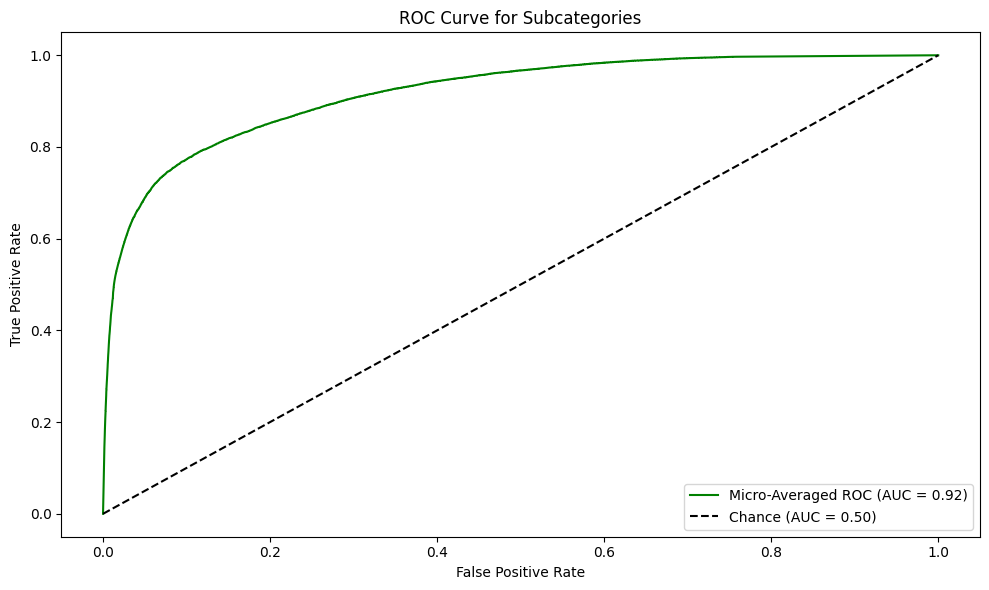

In [54]:
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from keras.utils import to_categorical

# Step 1: Generate predictions for test data
y_pred_subcategory_proba = subcategory_model.predict(X_test_dense)
y_pred_subcategory = y_pred_subcategory_proba.argmax(axis=1)

# Step 2: Calculate accuracy and classification report
subcategory_labels = list(range(len(subcategory_encoder.classes_)))

subcategory_accuracy = accuracy_score(y_test_subcategory, y_pred_subcategory)
print("Subcategory Test Accuracy:", subcategory_accuracy)

print("Subcategory Classification Report:\n", 
      classification_report(y_test_subcategory, y_pred_subcategory, target_names=subcategory_encoder.classes_, labels=subcategory_labels))

# Step 3: Plot ROC curve
y_test_subcategory_binary = to_categorical(y_test_subcategory, num_classes=len(subcategory_encoder.classes_))

fpr_sub, tpr_sub, _ = roc_curve(y_test_subcategory_binary.ravel(), y_pred_subcategory_proba.ravel())
auc_sub = roc_auc_score(y_test_subcategory_binary, y_pred_subcategory_proba, average="micro")

plt.figure(figsize=(10, 6))
plt.plot(fpr_sub, tpr_sub, label=f"Micro-Averaged ROC (AUC = {auc_sub:.2f})", color='green')
plt.plot([0, 1], [0, 1], 'k--', label="Chance (AUC = 0.50)")
plt.title("ROC Curve for Subcategories")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()



895/895 [==============================] - 3s 3ms/step
Testing Subcategory Accuracy: 0.5050490932597226
Testing Subcategory Classification Report:
               precision    recall  f1-score   support

           1       0.14      0.11      0.12        90
           2       0.13      0.07      0.09       711
           3       0.49      0.56      0.52       165
           4       0.57      0.39      0.46      1340
           5       0.06      0.02      0.03        51
           6       0.16      0.14      0.15        36
           7       0.14      0.08      0.10       171
           8       0.66      0.65      0.65      3523
           9       0.10      0.04      0.06       220
          10       0.16      0.24      0.19       187
          11       0.19      0.17      0.18        54
          12       0.49      0.34      0.40      1313
          13       0.36      0.27      0.31       130
          14       0.37      0.32      0.35       748
          15       0.26      0.25      0.

C:\ML\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ML\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ML\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


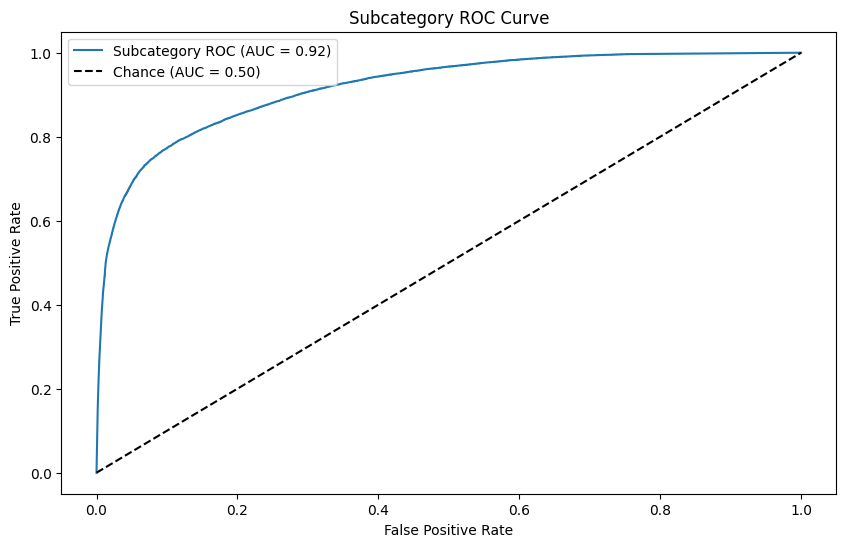

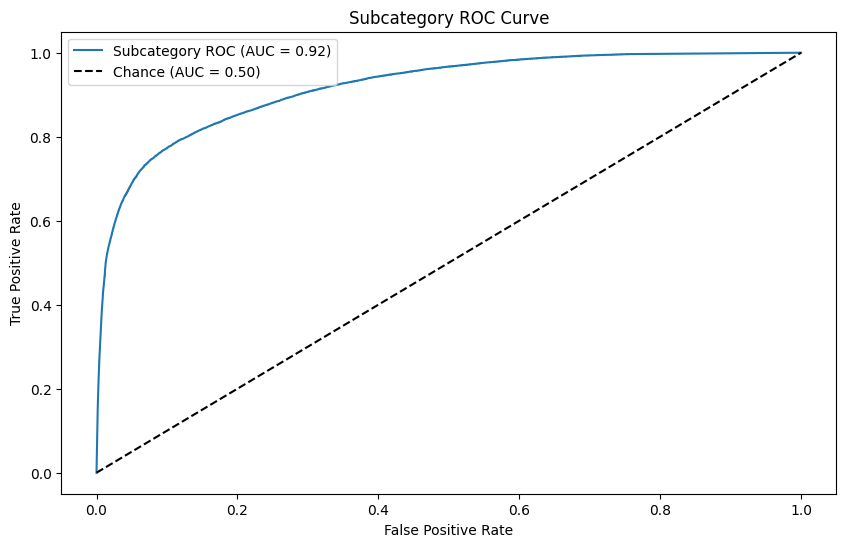

In [48]:
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Evaluate Subcategory Model
y_pred_subcategory_proba_test = subcategory_model.predict(X_test_dense)
y_pred_subcategory_test = y_pred_subcategory_proba_test.argmax(axis=1)

print("Testing Subcategory Accuracy:", accuracy_score(y_test_subcategory, y_pred_subcategory_test))
print("Testing Subcategory Classification Report:\n", classification_report(y_test_subcategory, y_pred_subcategory_test))

# ROC Curve for Subcategories
y_test_subcategory_binary = to_categorical(y_test_subcategory)
fpr_sub, tpr_sub, _ = roc_curve(y_test_subcategory_binary.ravel(), y_pred_subcategory_proba_test.ravel())
auc_sub = roc_auc_score(y_test_subcategory_binary, y_pred_subcategory_proba_test, average="micro")

plt.figure(figsize=(10, 6))
plt.plot(fpr_sub, tpr_sub, label=f"Subcategory ROC (AUC = {auc_sub:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Chance (AUC = 0.50)")
plt.title("Subcategory ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


# Ensure consistent encoding
from keras.utils import to_categorical

y_test_subcategory_binary = to_categorical(y_test_subcategory, num_classes=y_pred_subcategory_proba_test.shape[1])

# Compute ROC Curve
from sklearn.metrics import roc_curve, roc_auc_score
fpr_sub, tpr_sub, _ = roc_curve(y_test_subcategory_binary.ravel(), y_pred_subcategory_proba_test.ravel())
auc_sub = roc_auc_score(y_test_subcategory_binary, y_pred_subcategory_proba_test, average="micro")

# Plot ROC Curve
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(fpr_sub, tpr_sub, label=f"Subcategory ROC (AUC = {auc_sub:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Chance (AUC = 0.50)")
plt.title("Subcategory ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()



In [59]:
# Save the subcategory model
subcategory_model.save('LSTM_subcategory_model.h5')

# Save the category model
category_model.save('LSTM_category_model.h5')

print("Models saved successfully.")


Models saved successfully.


In [60]:
import joblib

# Save the encoders
joblib.dump(category_encoder, 'LSTM_category_encoder.pkl')
joblib.dump(subcategory_encoder, 'LSTM_subcategory_encoder.pkl')

print("Encoders saved successfully.")


Encoders saved successfully.
